# Introduction to Sentinel 2

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `cloud` and `cloud shadow`-free pixels. 

**Before you run this notebook:** You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

`module use /g/data/v10/public/modules/modulefiles`

`module load dea`

**Date**: September 2018.

**Author**: Claire Krause

In [2]:
%matplotlib inline
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import numpy as np

import sys
import os
# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../10_Scripts'))
import DEAPlotting
import DEADataHandling

# Replace '156' and 'cek156' with the path to your own home directory on the VDI
dc = Datacube(app='Intro to Sentinel2')

/g/data1a/r78/rt1527/dea-notebooks/10_Scripts/DEAPlotting.py:23: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


## See what Sentinel 2 products are currently available

In [3]:
products = dc.list_products()
display_columns = ['name', 'description', 'instrument',
                   'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
90,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,S2MSIARD,NaN,NaN
92,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
91,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2B,S2MSIARD,NaN,NaN
93,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

## Now we want to actually load and look at some data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [4]:
query = {
        'lat': (-35.27, -35.33),
        'lon': (149.07, 149.15),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2017-01-01', '2017-02-01')
        }

Canberra = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

### See what came back from the extraction

In [5]:
Canberra

<xarray.Dataset>
Dimensions:                (time: 2, x: 405, y: 380)
Coordinates:
  * time                   (time) datetime64[ns] 2017-01-05T00:02:12.026000 2017-01-15T00:02:11.026000
  * y                      (y) float64 -3.956e+06 -3.956e+06 ... -3.963e+06
  * x                      (x) float64 1.544e+06 1.544e+06 ... 1.553e+06
Data variables:
    azimuthal_exiting      (time, y, x) float32 24.918427 ... 127.58696
    azimuthal_incident     (time, y, x) float32 23.90676 39.06566 ... 149.86623
    exiting                (time, y, x) float32 10.383396 13.482613 ... 2.201671
    incident               (time, y, x) float32 36.450188 ... 30.279655
    relative_azimuth       (time, y, x) float32 26.75534 26.75521 ... 28.386116
    relative_slope         (time, y, x) float32 -1.0116673 ... 22.279266
    satellite_azimuth      (time, y, x) float32 100.57116 ... 100.57671
    satellite_view         (time, y, x) float32 4.7243457 4.723324 ... 4.0362
    solar_azimuth          (time, y, x) f

## About Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

### Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `nbar_green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `nbart_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

Note that the `nbart` data insert a missing value (`-9999`) into the dataset to denote a terrain shadow. This should be converted to a `NaN` value before using this data to avoid treating it as a valid value.


For more information on these corrections, see the explanation of the [Landsat archive data](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

## Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f383a7204e0>)

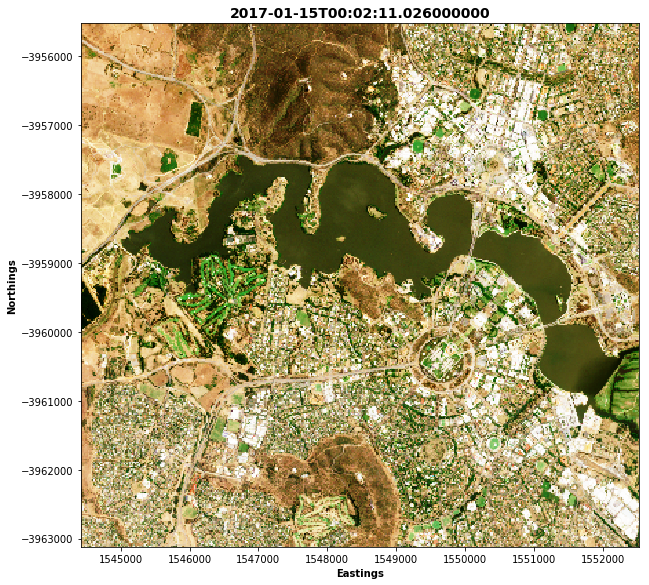

In [6]:
DEAPlotting.three_band_image(Canberra, bands=['nbar_red', 'nbar_green', 'nbar_blue'],
                             contrast_enhance=True, time=1)

## Plot this scene up as false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f383a765f60>)

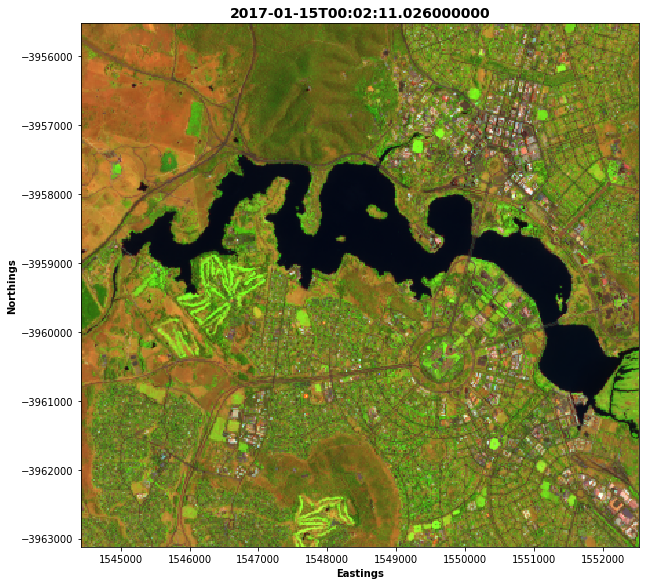

In [7]:
DEAPlotting.three_band_image(
    Canberra, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=1)

## Compare some scenes side-by-side

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<module 'matplotlib.pyplot' from '/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/matplotlib/pyplot.py'>,
 <Figure size 720x720 with 2 Axes>)

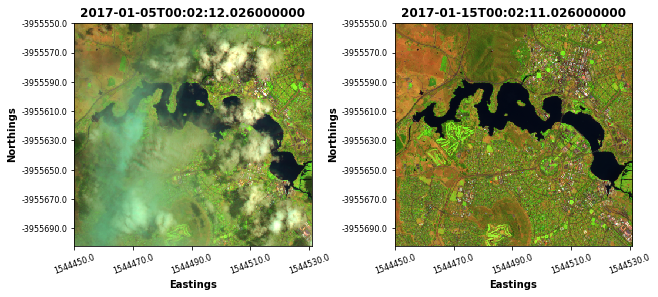

In [8]:
DEAPlotting.three_band_image_subplots(Canberra, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'],
                                      num_cols=2, figsize=[10, 10], wspace=0.35)

## Filter scenes using pixel quality

A pixel quality dataset (`fmask`) is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows. 

The `fmask` field contains values from 0 to 5. 

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

### Here is the cloudy image we would like to mask

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f388c082080>)

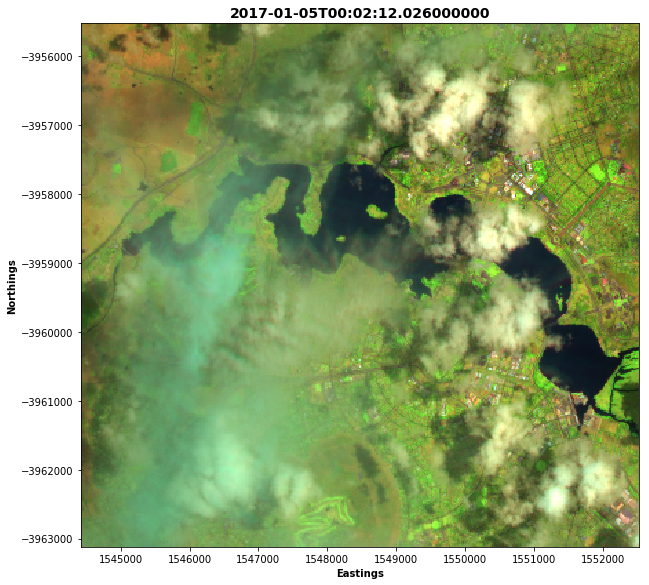

In [12]:
DEAPlotting.three_band_image(
    Canberra, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=0)

### Plot up the pixel quality information for the same scene

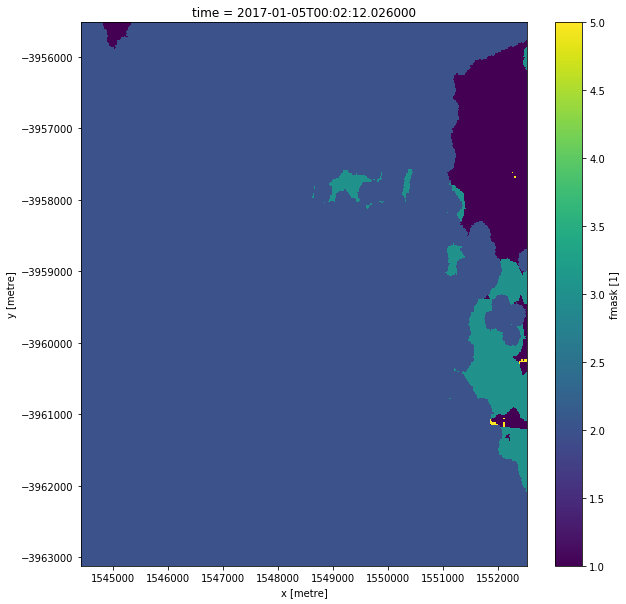

In [14]:
Canberra.isel(time=0).fmask.plot(figsize=[10, 10])

### Now use the pixel quality information to create a mask, and apply it to the spectral data

We want to filter out no data, cloud and cloud shadow, so we will use the `fmask` values `0`, `2` and `3` for our filter.

In [15]:
clear_pixels = np.logical_and(np.logical_and(Canberra.fmask != 0, Canberra.fmask != 2),
                              Canberra.fmask != 3)
Clear_Canberra = Canberra.where(clear_pixels)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f388c0749b0>)

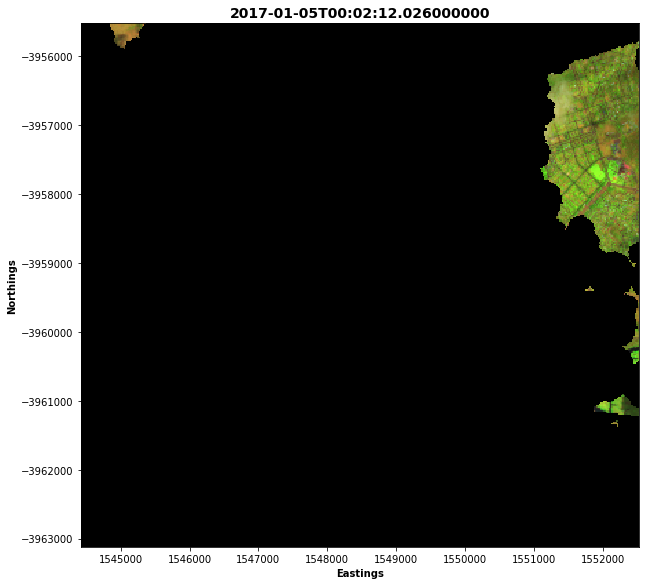

In [17]:
DEAPlotting.three_band_image(Clear_Canberra, bands=['nbar_swir_2', 'nbar_nir_1', 'nbar_green'], time=0)